# Max Cut Problem Example

### James Saslow
### 12/11/2023

### Problem Statement:

Suppose you had a node network like 

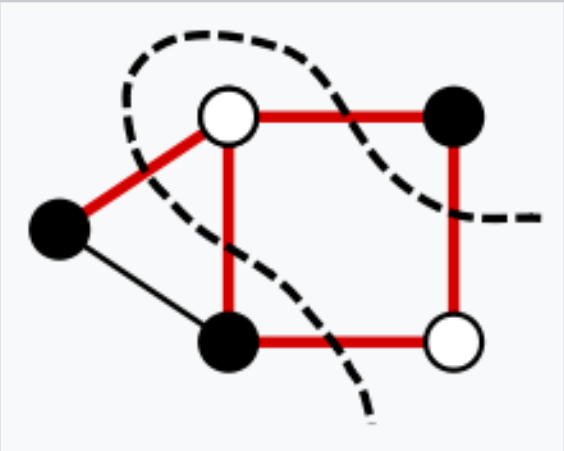

for example.

The goal of max cut is to draw a continuous line (shown by the dotted line above) that cuts the maximum number of connections (edges) between the nodes.

In doing so, we can partition each node into two groups (White nodes and black nodes in this example).

This cut achieves $5$ cuts in total, which is the max cut for this graph. This solution, however, is not unique and there are other cuts you can do that will also yield a max cut of $5$. (Try to find them!)

To better work with networks, we will use the **networkx** package to better visualize node networks and translate their information over to the DWave QUBO formulation.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

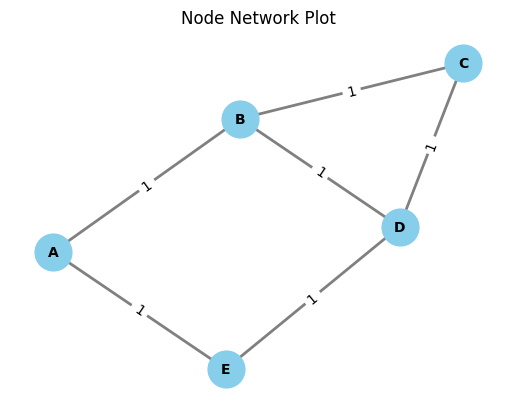

In [6]:
G = nx.Graph() # Prompting an empty node network

# Adding edges to the node network with equal weights of 1
G.add_edge("A", "B", weight=1)
G.add_edge("B", "C", weight=1)
G.add_edge("C", "D", weight=1)
G.add_edge("D", "E", weight=1)
G.add_edge("D", "B", weight=1)
G.add_edge("E", "A", weight=1)



# Plotting the node network
plt.title('Node Network Plot')
pos = nx.spring_layout(G) # Explain what this does
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue",
        font_size=10, font_color="black", font_weight="bold", width=2, edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

As we can see, we have a node network that represents the problem statement from above. 

### Now, let's try to formulate a cost function for max cut


We will let the cost function be functions of spin variables at first. So, $-1$'s and $+1$'s. But, we will convert to the QUBO formalism later.

The expression for the cost function for the max cut problem is

$$C(Z) = \sum_{(i,j)} w_{i,j} \frac{1-z_{i}z_{j}}{2}$$

where $C(Z)$ represents the number of cut connections in the graph. And, as one would assume, the goal of max cut is to maximize the number of cuts in the graph by maximizing $C(Z)$.

The spin variable $z_{i}$ can either take on $-1$ or $+1$ and represents the classification of the $ith$ node. When we do a max cut, what we're acutally trying to do is partition the set of nodes into the $+1$ group and another set of nodes into the $-1$ group.


The $w_{i,j}$ is the *weight* term and it symbolizes how valuable each cut is. Here, we initialized all relevant connections to have a weight of 1, making each cut equally as valuable. However, because the cost function does a sum over $(i,j)$, which is all possible node combinations, the nodes that do not have a connection (i.e. nodes B and E) will have a weight of $0$ in the sum.


So, why does the cost function $C(Z) = \sum_{(i,j)} w_{i,j} \frac{1-z_{i}z_{j}}{2}$ work?

Well let's say that $i = A$ and $j = B$ and we want to determine the cost value between these 2 nodes i.e.

$C_{A,B} = w_{A,B}\frac{1-z_{A}z_{B}}{2}$

we can see that there is indeed a connection between nodes $A$ and $B$ in the graph, so $w_{A,B} = w_{B,A} = 1$. If there wasn't a direct connection, then this weight term between $A$ and $B$ would be $0$.

$C_{A,B} = \frac{1-z_{A}z_{B}}{2}$

What if $A$ and $B$ were part of the same class? (i.e. $+1$)

If $A$ and $B$ were part of the same $+1$ class, we can substitute $z_{A} = 1$ and $Z_{B}$ into $C_{A,B}$ and see what happens

$C_{A,B} = \frac{1-(+1)(+1)}{2} = \frac{1-1}{2} = 0$

$C_{A,B} = 0$ means **do not** make a cut between $A$ and $B$.

But what if, for example, this time, $A$ and $B$ were part of different classes? (i.e. $z_{A} = +1$ and $z_{B} = -1$)

We can substitute these values into the cost function $C_{A,B} = \frac{1-z_{A}z_{B}}{2}$

$C_{A,B} = \frac{1-(+1)(-1)}{2} = \frac{1 + 1}{2} = 1$

$C_{A,B} = 1$ means **cut** the connection between $A$ and $B$ because they are part of different classes.

### Let's convert from spin variables to QUBO

So far, we have used QUBO implementation on DWave solvers, so we will stick with that technique. The problem is we have a cost function in terms of spin variables $-1, +1$ and we want to write our cost function in terms of binary variables $0,1$. So we need to make a transformation like

$-1 \rightarrow{} 0$

$+1 \rightarrow{} 1$

and it turns out that the following linear transformation accomplishes that

Let $x = \frac{z+1}{2}$ where $x$ are the binary variables and $z$ are the spin variables.

Making this substitution, the cost function transforms from spin variables

$$C(Z) = \sum_{(i,j)} w_{i,j} \frac{1-z_{i}z_{j}}{2}$$

to binary variables

$$C(X) = \sum_{(i,j)} w_{i,j} (x_{i} + x_{j} - 2 x_{i}x_{j})$$

where $C(X)$ still is the number of cuts on a node network

and because DWave solvers always find the minimum of the cost function, and we want to find the maximum (to get the maximum cut ) we need to write $C'(X)$, a new cost function where the minimum of $C'(X)$ is the maximum of $C(X)$

$C'(X) = \sum_{(i,j)} w_{i,j} (-x_{i} -x_{j} + 2 x_{i}x_{j})$

### Solving the $C'(X) = \sum_{(i,j)} w_{i,j} (-x_{i} -x_{j} + 2 x_{i}x_{j})$ cost function on DWave

In [30]:
bqm = BinaryQuadraticModel('BINARY') # Empty QUBO Template

for edge in G.edges:
    i,j = edge # Getting the nodes that share an edge and storing them in i,j
    bqm.add_variable(i,-1)
    bqm.add_variable(j,-1)
    weight = G[i][j]['weight']
    bqm.add_interaction(i,j,2*weight)
    
bqm

BinaryQuadraticModel({'A': -2.0, 'B': -3.0, 'E': -2.0, 'C': -2.0, 'D': -3.0}, {('B', 'A'): 2.0, ('E', 'A'): 2.0, ('C', 'B'): 2.0, ('D', 'B'): 2.0, ('D', 'E'): 2.0, ('D', 'C'): 2.0}, 0.0, 'BINARY')

In [31]:
# Solve the problem using D-Wave
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=10)

In [32]:
# Post-Processing Solver Output
opt_solution = sampleset.first.sample # Binary Bit-String that minimizes the cost function
opt_value = sampleset.first.energy    

In [33]:
print('X_min = ', opt_solution)
print('C_min = ', opt_value)

X_min =  {'A': 0, 'B': 1, 'C': 0, 'D': 0, 'E': 1}
C_min =  -5.0


### Thus we achieve a max cut of 5 where we have 3 items in one category, and 2 items in the other catagory

We can help visualize this by color coding the nodes on the node network.

Blue = Class '0'
Red = Class '1'


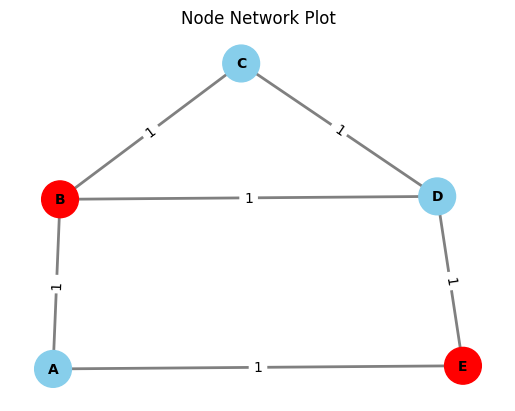

In [43]:
colors = []
for i in opt_solution.values():
    if i == 0:
        colors.append("skyblue") # Items in class '0' are blue
    else:
        colors.append("red") # Items in class '1' are red

        
print("Blue = Class '0'")
print("Red = Class '1'")
        
        
# Plotting the node network
plt.title('Node Network Plot')
pos = nx.spring_layout(G) # Explain what this does
nx.draw(G, pos, with_labels=True, node_size=700, node_color=colors,
        font_size=10, font_color="black", font_weight="bold", width=2, edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### Sources


[1] Dwave-Examples, “Dwave-examples/maximum-cut: Solve a max-cut problem using a quantum computer,” GitHub, https://github.com/dwave-examples/maximum-cut (accessed Dec. 11, 2023). 

[2] “Max-cut and traveling salesman problem#,” Max-Cut and Traveling Salesman Problem - Qiskit Optimization 0.6.0, https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html (accessed Dec. 11, 2023). 

[3] “21.Classical optimization: Maxcut problem,” YouTube, https://www.youtube.com/watch?v=LMmQ5LD308A (accessed Dec. 11, 2023). 

[4] “Binary quadratic models#,” Binary Quadratic Models - Ocean Documentation 6.7.1 documentation, https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html (accessed Dec. 11, 2023). 

[5] “Quantum programming tutorial | D-wave qubits 2021,” YouTube, https://www.youtube.com/watch?v=jTDnGox0c9Y (accessed Dec. 11, 2023). 